In [1]:
from matplotlib import pyplot as plt
from matplotlib.patches import Circle

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from pylab import *

import pickle
import keras
import loadnotebook
from predictionhelper import *

import warnings
warnings.filterwarnings('ignore')

/home/izza/installdir/miniconda3/envs/stock/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


importing Jupyter notebook from predictionhelper.ipynb


# Predicted Data Preparation 

In [2]:
x_cut = 50  
y_cut = 100 

old_origin_img = cv2.imread('../image/map.png',0)
crop = old_origin_img[100:318, 50:927]
crop = cv2.cvtColor(crop, cv2.COLOR_GRAY2RGB)

x_coord_list = []
y_coord_list = []
pci_list = []
for lon in range(0, crop.shape[1]) :
    for lat in range(0, crop.shape[0]) :
        x_coord_list.append(x_cut + lon)
        y_coord_list.append(y_cut + lat)
        
background = get_map_image(black_white=True)
x_coord_view = [lon for lon in x_coord_list]
y_coord_view = [lat for lat in y_coord_list]

generated_function = [generate_predicted_data_pci, 
                      generate_predicted_data_rsrp, 
                      generate_predicted_data_rsrq, 
                      generate_predicted_data_snr]

all_x_pci = pd.DataFrame({'location_x':x_coord_list, 'location_y':y_coord_list})

normalize_rsrq = matplotlib.colors.Normalize(vmin=-9, vmax=-5)
normalize_snr = matplotlib.colors.Normalize(vmin=0, vmax=30)

# Predict 

In [3]:
prediction_columns = ["PCI", "RSRP", "RSRQ", "SNR"]
# min 1, max 3
pred_index = 2
set_val = 1
powers = {37:-2, 38:3, 39:0, 40:5, 41:-1, 42:16}
ml_name = 'xgboost'
training_method = 'baseline'  
training_method = 'independent_set_%d' % (set_val) 
training_method = 'transfer_except_%d' % (set_val) 
training_method = '20_bayesian_independent_%d' % (set_val) 

In [4]:
pred_col = prediction_columns[pred_index]
model_name = 'db/%s_%s_%s' % (pred_col, ml_name, training_method)
model = pickle.load(open(model_name + ".pickle.dat", "rb"))
normalized = [None, None, normalize_rsrq, normalize_snr]

In [5]:
def add_custom_feature(df, power_val) :
    for p in power_val :
        df["Power_" + str(p)] = power_val[p]
    df = add_distance(df)
    df = add_angle_map(df)
    return df

In [6]:
if set_val is None :
    all_x_data = add_custom_feature(pd.DataFrame(all_x_pci), powers)
else :
    all_x_data = add_features(pd.DataFrame(all_x_pci), 6, set_val)
    beam_columns = [c for c in all_x_data if "beam" in c]
    all_x_data = all_x_data.drop(beam_columns, axis=1)

if 'transfer' not in training_method:
    all_x_data['set'] = set_val if set_val is not None else 0

In [8]:
for i in range(pred_index+1) :
    if i == 0 :
        if 'set' in all_x_data.columns :
            all_x_data = all_x_data.drop(['set'], axis=1)
        
        all_x_data['priority'] = 6 
        if 'transfer' not in training_method :
            all_x_data['set'] = set_val if set_val is not None else 0
            
    if i == 1  :
        if 'priority' in all_x_data.columns :
            all_x_data = all_x_data.drop(['priority'], axis=1)
        all_x_data['set'] = set_val if set_val is not None else 0
    
    model_name = 'db/%s_%s_%s' % (prediction_columns[i], ml_name, training_method)
    print(i, model_name)
    model = pickle.load(open(model_name + ".pickle.dat", "rb"))
    all_x_data[prediction_columns[i]] = model.predict(all_x_data)

    if i == 0 :
        all_x_data["PCI"] = all_x_data["PCI"].apply(lambda x : pci_decode[x])
        
    c = [x for x in all_x_data.columns]
    all_x_data = all_x_data[c[:2+i] + c[-1:] + c[2+i:-1]]

0 db/PCI_xgboost_20_bayesian_independent_1
1 db/RSRP_xgboost_20_bayesian_independent_1
2 db/RSRQ_xgboost_20_bayesian_independent_1


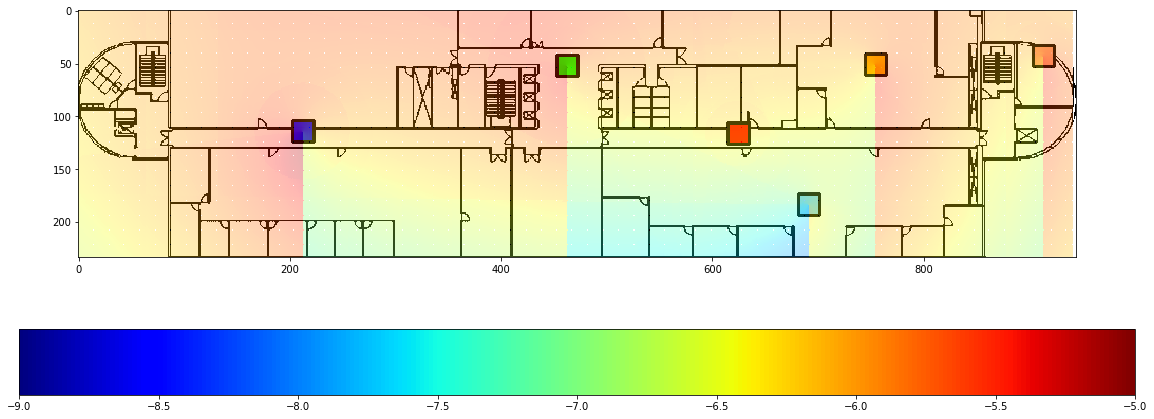

In [9]:
all_y = all_x_data[prediction_columns[pred_index]]

if normalized[pred_index] is None :
    normalize = matplotlib.colors.Normalize(vmin=min(all_y), vmax=max(all_y))
else :
    normalize = normalized[pred_index]
    
data_pred = [cmap(normalize(value))[:3] for value in all_y]
data_pred = [[int(x*255) for x in value] for value in data_pred]
set_val_name = set_val if set_val is not None else 0
path = "../results/predicted/%s/%s/priority_%d_set_%d.png" % (pred_col.lower(), ml_name, 6, set_val_name)
a=visualize_all_location_heatmap(get_map_image(black_white=True), x_coord_view, y_coord_view, data_pred, 
                                 cmap, normalize, filename=path,
                                 size=1, figsize=(20,10), adjustment=True)